In [49]:
# plotting
import matplotlib.pyplot as plt

# arrays and math
import numpy as np

# image processing
import cv2

# opening files and paths
import os

from shapely_conversion import convert
from shapely_utilities import *

import spiral_path as S
from spiral_path import calculate_point, calculate_point_contour

import fermat_spiral as FS

# optimization module
from optimization import optimization

import time

In [2]:
'''
Plot a single path
'''
def plot_path(path, color=None):
    
    X = []
    Y = []

    for p in path:
        X.append(p[0])
        Y.append(p[1])
        
    plt.plot(X,Y,c=color)


'''
Plot a list of paths
'''
def plot_recursive_path(total_path, color=None):
    
    rest = []
    
    for path in total_path:
        if type(path) is list:
            plot_path(path, color)
            if path:
                pyplot.scatter(path[0][0], path[0][1], c='green')
                pyplot.scatter(path[-1][0], path[-1][1], c='red')
        else:
            rest.append(path)
            
    plot_path(rest, color)

In [3]:
# this generates the total path without combining the paths
def generate_total_path(result, distance):
    
    total_path = []
    contour_family = []
    
    # loop through each value in the result
    for branch in result:
        if type(branch) is list:  
            total_path.extend(generate_total_path(branch, distance))
        else:
            contour_family.append(branch)

    results = S.execute(contour_family, distance)

    total_path.append(results)

    return total_path

In [4]:
# this generates the total path without combining the paths
def generate_total_pathf(result, distance):
    
    total_path = []
    contour_family = []
    
    # loop through each value in the result
    for branch in result:
        if type(branch) is list:  
            total_path.extend(generate_total_pathf(branch, distance))
        else:
            contour_family.append(branch)

    s_path = S.execute(contour_family, distance)
            
    results = FS.convert_fermat(s_path,distance)

    total_path.append(results)

    return total_path

In [5]:
# this creates a fermat path recursively from a tree of Polygon objects
def generate_fermat_path(result, distance):
    
    branches = []

    contour_family = []

    # loop through each node or branch in the tree
    for node in result:
        
        # if the result node is a branch, recursively call this function on it
        if type(node) is list:
            branches.append(generate_fermat_path(node, distance))
        # if the result node is not a branch, add it to the contour family
        else:
            contour_family.append(node)

    # generate the fermat spiral from the root and the branches
    # check that the length of the path is correct
    
    spiral = S.execute(contour_family, distance)       
    root = FS.convert_fermat(spiral,distance)
    
    # combine the root and the branches
    if root:
        return FS.combine_paths(root, branches, distance)
    
    # if there is no root (not sure how this happens but it does) - just return the branches?
    else:
        return branches

In [67]:
# execute runs the path function "fnc" on an image
# - use this to generate the path from an image
def execute(image, distance, fnc, optimize=False):
    
    opt_reg=1
    opt_smh=10
    opt_spacing=1
    
    total_path = []
    
    start = time.time()
    
    # create the polygons from the image
    polygons = convert(image, approximation = cv2.CHAIN_APPROX_SIMPLE)
    
    print("Polygon:", time.time()-start)
    
    formatted_polygons = []
    
    # each individual polygon should be a separate distinct polygon in the image
    for polygon in polygons:
        
        '''
        Simplify the polygon first (all exterior and interiors)
        '''
        if optimize:
            
            optimize_time = time.time()
            s = list(sample(polygon.exterior,distance).coords)
            
            if len(s) > 5:
                ext = optimization(s, opt_reg, opt_smh, opt_spacing, False)

                ints = []

                for interior in polygon.interiors:
                    i = list(sample(interior,distance).coords)
            
                    if len(i) > 5:
                        ints.append(optimization(i, opt_reg, opt_smh, opt_spacing, False))

                polygon = Polygon(ext, holes=ints)

                print("\tOptimize:", time.time()-optimize_time)
                
                # simplify the shape
                polygon = polygon.simplify(0.5)

        else:
            polygon = polygon.simplify(0.5)
            print(polygon.type)
        
        formatted_polygons.append(polygon)
        
        
        dt_time = time.time()
        # generate the distance transform for the polygon
        result = distance_transform(polygon, -distance)
        
        print("\tDistance Transform:", time.time()-dt_time)
        
        path_time = time.time()
        
        # if there is a result, run the path generation function on the result
        if result:
            if fnc == generate_fermat_path:
                total_path.extend([fnc(result, distance)])
            else:
                total_path.extend(fnc(result, distance))

            
        print("\tPath:", time.time()-path_time)
    
    print("Total:", time.time()-start)
    
    return total_path, formatted_polygons

In [68]:
%reload_ext autoreload
%autoreload 2

In [170]:
%%time
%matplotlib notebook
'''
This cell runs the complete pipeline from image to CFS output
'''

# distance in between each contour
distance = 1

# filename of image to process
filename = 'files/gear.png'

# image should be in binary format
image = cv2.imread(filename,0)

print(not image is None)

# generate the un-connected fermat spiral output
# settings: simplify - True, optimize - False (flip this to true to see effect), optimize locally - True
#           penalize points for moving away from their original position: 1
#           penalize points for violating mid-point scheme: 5
#           spacing penalization is not implemented yet. The last term means nothing for now
# results = execute(image, distance, generate_total_pathf, False)
# plot_recursive_path(results)


True
CPU times: user 3.24 ms, sys: 54 µs, total: 3.3 ms
Wall time: 11.4 ms


Polygon: 0.0023751258850097656
	Optimize: 1.1198139190673828
	Distance Transform: 0.013061285018920898
	Path: 0.6881730556488037
Total: 1.8291544914245605


<IPython.core.display.Javascript object>


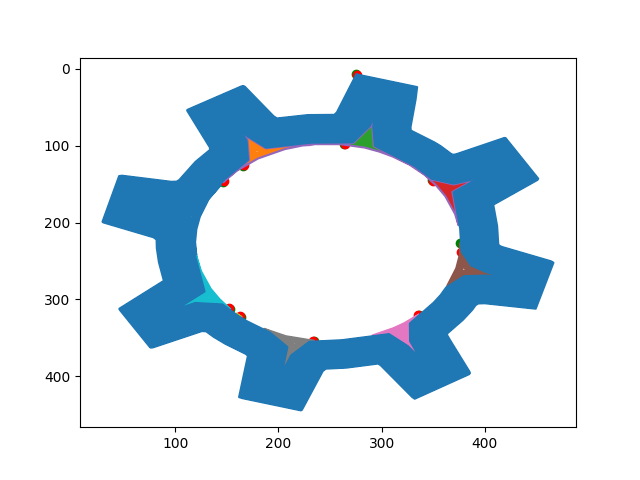

In [171]:

results, polygons = execute(image, distance, generate_total_pathf, True)
    
plot_recursive_path(results)
plt.gca().invert_yaxis()
plt.show()

In [162]:
%%time

distance = 2
result = execute(image, distance, generate_fermat_path, True)

print(len(result[0]))

Polygon: 0.007333517074584961
	Optimize: 0.011924982070922852
	Distance Transform: 9.322166442871094e-05
	Path: 4.76837158203125e-07
	Optimize: 0.016141414642333984
	Distance Transform: 0.0001971721649169922
	Path: 0.0011429786682128906
	Optimize: 0.01548314094543457
	Distance Transform: 0.00042176246643066406
	Path: 0.0019578933715820312
	Optimize: 0.014443635940551758
	Distance Transform: 0.0002620220184326172
	Path: 0.0019867420196533203
	Optimize: 0.02630782127380371
	Distance Transform: 0.0006220340728759766
	Path: 0.016299009323120117
	Optimize: 0.06581497192382812
	Distance Transform: 0.002305269241333008
	Path: 0.1096653938293457
	Optimize: 0.01504826545715332
	Distance Transform: 0.0001518726348876953
	Path: 0.00036907196044921875
	Optimize: 4.972106695175171
	Distance Transform: 0.055684566497802734
	Path: 123.42851853370667
Total: 128.79567122459412
7
CPU times: user 2min 9s, sys: 4.51 s, total: 2min 13s
Wall time: 2min 8s


In [30]:
%%time

distance = 2
result = execute(image, distance, generate_fermat_path, False)

print(len(result[0]))

Polygon: 0.006737709045410156
Polygon
	Distance Transform: 0.009950399398803711
	Path: 6.753263711929321
Total: 6.775867462158203
4423
CPU times: user 6.78 s, sys: 4 ms, total: 6.79 s
Wall time: 6.78 s


In [70]:
Point((0,0)).buffer(1).area

3.1365484905459384

In [148]:
result[0][0]

[(95.3916103450845, 17.515621112082908),
 (89.84564995036916, 20.944920134055675),
 (83.71763141300396, 26.969086628014676),
 (69.62954743043693, 50.04077366156542),
 (66.27552880123272, 57.91936965219248),
 (64.02324596607767, 65.91982071802306),
 (63.022244246133845, 80.64796881966575),
 (62.19212195568969, 86.286700567513),
 (59.915675628384456, 91.6236739379833),
 (55.40947916586065, 96.00611966387062),
 (49.682488593611026, 98.09224848446512),
 (34.53003300795158, 97.49904419565952),
 (30.362803356594128, 97.77719052295205),
 (27.265015069529753, 98.7064626788569),
 (24.826729255020055, 100.25368970414497),
 (23.015924704059092, 102.4309500697407),
 (21.99892123764926, 105.04832812939581),
 (21.744601832912217, 108.1290983466516),
 (22.306199924762726, 111.3112163692566),
 (25.662575105107596, 118.81281202633507),
 (45.332031888618715, 145.845337900661),
 (47.70711442839113, 150.76659887289856),
 (50.410015315892984, 160.64575707427844),
 (50.6415973719573, 171.36735943105282),
 (

In [155]:
result[0]

[[(446.50305121430546, 582.1539706275637),
  (448.33667395530375, 582.0328432263503),
  (451.7767963420094, 580.8776512950169),
  (452.52093430772686, 580.4144657663503),
  (452.0231369239534, 580.2590511419505),
  (451.1566055641161, 580.325196563711)],
 [(522.188183937457, 567.8251700120459),
  (527.4821465116516, 572.9814623860983),
  (547.0098396646554, 587.0699851370316),
  (564.4479445198425, 598.1957259005908),
  (566.6065098952731, 600.0873665841393),
  (558.8813630466474, 590.4118696414725),
  (528.3748829141892, 572.897504083895),
  (526.0547554922733, 570.9952842704733)],
 [(428.8291923636499, 411.5470698841324),
  (434.84220334550866, 415.3630784970775),
  (438.0712563669861, 419.01475923546144),
  (443.4077767369209, 430.8921448171724),
  (447.2817286199414, 436.74675759183765),
  (449.18754529950075, 438.8205414630245),
  (454.5963875267766, 442.28062507382015),
  (474.4426627397841, 448.2076396000722),
  (477.02052105693593, 448.75600967441426),
  (475.5910613767791, 446

In [166]:
def recursive(path):
    
    
    for p in path:
        if p:
            if type(p[0]) == tuple:
                plot_path(p)
            else:
                recursive(p)
    

In [160]:
result[-1]

intersections 0


<IPython.core.display.Javascript object>


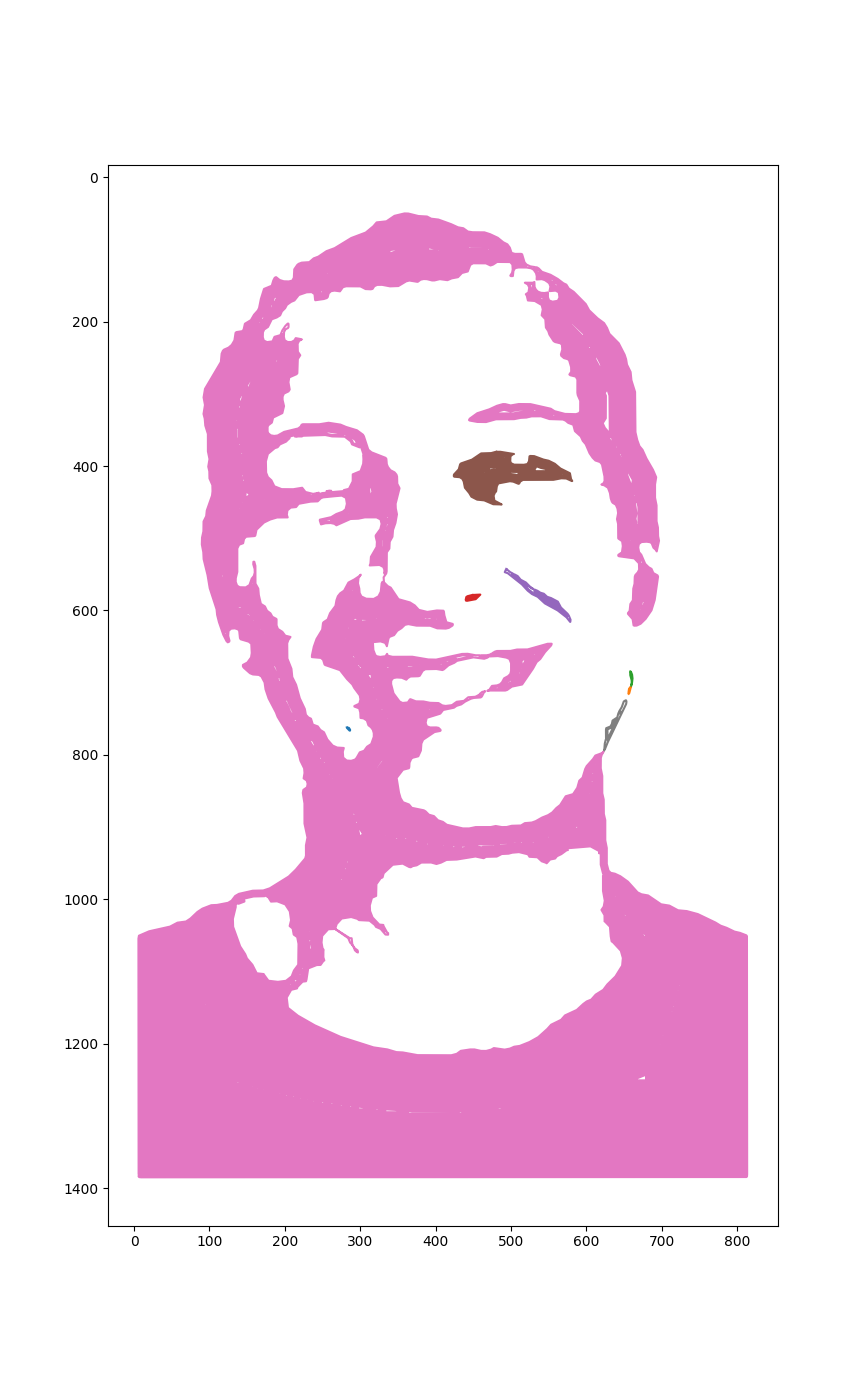

In [167]:
%matplotlib notebook

test = LineString(result[0][0])

intersections = self_intersections_binary(test)

print("intersections", len(intersections))

for i in intersections:
    pyplot.scatter(i.x,i.y)
    print(i.x,i.y)

recursive(result[0])
pyplot.gca().invert_yaxis()

In [168]:
from metrics import Metrics

measurer = Metrics(segments=True, commands=True, curvature=False, fill=True)

In [169]:
measurer.measure(result[0], "CFS", distance, polygons)

AssertionError: 

In [140]:
path_areas = [LineString(path).buffer(distance/2+0.001) for path in result[0]]

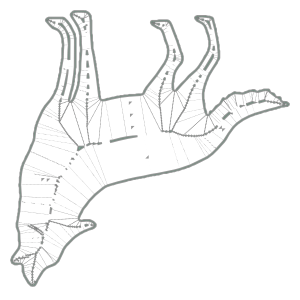

In [141]:
MultiPolygon(polygons).difference(MultiPolygon(path_areas))

In [112]:
MultiPolygon(path_areas).difference(MultiPolygon(polygons))

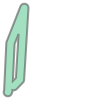

In [80]:
p = LineString(results[0]).buffer(distance/2)
p

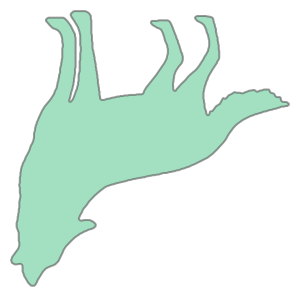

In [84]:
from shapely.geometry import MultiPolygon
MultiPolygon(polygons)

In [53]:
from x import y

ModuleNotFoundError: No module named 'x'

In [ ]:

from gcode import GcodeWriter

In [ ]:
gc = GcodeWriter(filename='wolf.gcode', scale = 0.1)

gc.convert([results])

In [ ]:
LineString()

In [ ]:
polygon = convert(image, 5)[0]

In [ ]:
ls = polygon.exterior


opt_reg = 1
opt_smh = 200
opt_spacing = 1
opt_local = True


# test optimization on input image
opt = optimization(list(ls.coords), opt_reg, opt_smh, opt_spacing, False)

#plot_path(list(ls.coords))
plot_path(opt)

In [ ]:
# test optimization on advanced image
# test optimization on input image
opt = optimization(list(sample(ls,3).coords), opt_reg, opt_smh, opt_spacing, False)

#plot_path(list(ls.coords))
plot_path(opt)

In [ ]:
LineString(results).is_simple

In [18]:
# helper function to display the format of the "result" tree
# - the "result" tree is the representation of the distance transform 
# - EX: A tree of "['X','X','X', ['X',['X','X'], ['X']], ['X']]" has...
# 1. Three successive outer contours (no branches)
# 2. A branch with a single contour with a depth-2 branch and a depth-1 branch
# 3. A branch with a single contour

# TODO there is probably a better way to set up the trees in this scenario
def simplify_tree(result):
    
    root = []
    output = []
    for b in result:
        if type(b) is list:
            output.append(simplify_tree(b))
            
    return ["X"] + output

In [ ]:
def remove_short_paths(temp_path, length=20):
    
    clean_path = []
    
    for path in temp_path:
        
        if LineString(path).length > length:
            clean_path.append(path)
    
    return clean_path